# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [1]:
# Custom
import data_processing
import run

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile
import pickle

# Processing
import gc
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [ ]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [ ]:
def extract(state):
    # For each listed dataset string in the EXPECTED_DATASETS constant
    for datasetName in EXPECTED_DATASETS[state]:
        try:
            # Open the given archive file
            with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
                # Build the target directory path for extracted data
                datasetNameTokens = datasetName.split('.')
                datasetNameTokens.remove('zip')
                targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)

                # If the target directory doesn't exist, create it
                if not os.path.exists(targetDirectory):
                    Path(targetDirectory).mkdir()

                # Extract all data from the archive file to the target directory
                currentZip.extractall(targetDirectory)
        except FileNotFoundError:
            print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [ ]:
state = 'Colorado'
counties = {'Colorado': ['Boulder', 'Grand', 'Larimer', 'Logan', 'Weld', 'Yuma']}

if not os.path.exists(f'../data/control.{state}.pkl'):
    print("Processing COVID dataset")
    flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path(f'../data/covid_county.{state}/data.json'))))
    flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path(f'../data/covid_county.{state}/linkedGeometry.json'))))

    print("Combining data geometry for COVID dataset")
    combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(
        flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

    combinedCovidFrame = combinedCovidFrame[combinedCovidFrame.county.isin(counties[state])]
    combinedCovidFrame['date'] = pd.to_datetime(combinedCovidFrame['dateString']).dt.date
    print("Finding County Geometries")
    county_polygons = data_processing.create_county_polygons(state, combinedCovidFrame)
    combinedCovidFrame.to_pickle(f'../data/control.{state}.pkl')
else:
    combinedCovidFrame = pd.read_pickle(f'../data/control.{state}.pkl')


#### NEON 2D Wind Dataset

In [ ]:
if not os.path.exists(f'../data/covidWind.{state}.pkl'):
    print('Processing Wind data')
    flattenedWindDataFrame = pd.json_normalize(json.load(open(Path(f'../data/neon_2d_wind.{state}/data.json'))))
    flattenedWindGeometryFrame = pd.json_normalize(
        json.load(open(Path(f'../data/neon_2d_wind.{state}/linkedGeometry.json'))))
    flattenedWindGeometryFrame['county'] = flattenedWindGeometryFrame.apply(
        lambda row: data_processing.lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
    combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
    combinedWindFrame['date'] = pd.to_datetime(combinedWindFrame['startDateTime']).dt.date
    combinedWindFrame['datetime'] = pd.to_datetime(combinedWindFrame['startDateTime']).dt.round("H")
    finalCovidWindFrame = pd.merge(combinedWindFrame, combinedCovidFrame, how='left', left_on=['county', 'date'],
                                   right_on=['county', 'date'])
    finalCovidWindFrame = finalCovidWindFrame[finalCovidWindFrame['totalCaseCount'].notna()]
    finalCovidWindFrame.to_pickle(f'../data/covidWind.{state}.pkl')
    del finalCovidWindFrame
    del combinedWindFrame
    del flattenedWindDataFrame
    gc.collect()

#### NEON Barometric Pressure Dataset

In [ ]:
if not os.path.exists(f'../data/covidPressure.{state}.pkl'):
    print('Processing Pressure data')
    flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path(f'../data/neon_barometric_pressure.{state}/data.json'))))
    flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path(f'../data/neon_barometric_pressure.{state}/linkedGeometry.json'))))
    flattenedPressureGeometryFrame['county'] = flattenedPressureGeometryFrame.apply(
        lambda row: data_processing.lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
    combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(
        flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
    combinedPressureFrame['date'] = pd.to_datetime(combinedPressureFrame['startDateTime']).dt.date
    combinedPressureFrame['datetime'] = pd.to_datetime(combinedPressureFrame['startDateTime']).dt.round("H")
    finalCovidPressureFrame = pd.merge(combinedPressureFrame, combinedCovidFrame, how='left',
                                       left_on=['county', 'date'], right_on=['county', 'date'])
    finalCovidPressureFrame = finalCovidPressureFrame[finalCovidPressureFrame['totalCaseCount'].notna()]
    finalCovidPressureFrame.to_pickle(f'../data/covidPressure.{state}.pkl')
    del finalCovidPressureFrame
    del combinedPressureFrame
    del flattenedPressureDataFrame
    gc.collect()

#### NEON Air Temperature

In [ ]:
if not os.path.exists(f'../data/covidTemperature.{state}.pkl'):
    print("Processing Temperature data")
    flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path(f'../data/neon_single_asp_air_temperature.{state}/data.json'))))
    flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path(f'../data/neon_single_asp_air_temperature.{state}/linkedGeometry.json'))))
    flattenedTemperatureGeometryFrame['county'] = flattenedTemperatureGeometryFrame.apply(
        lambda row: data_processing.lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
    combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(
        flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
    combinedTemperatureFrame['date'] = pd.to_datetime(combinedTemperatureFrame['startDateTime']).dt.date
    combinedTemperatureFrame['datetime'] = pd.to_datetime(combinedTemperatureFrame['startDateTime']).dt.round("H")
    finalCovidTemperatureFrame = pd.merge(combinedTemperatureFrame, combinedCovidFrame, how='left', left_on=['county', 'date'],
                                          right_on=['county', 'date'])
    finalCovidTemperatureFrame = finalCovidTemperatureFrame[finalCovidTemperatureFrame['totalCaseCount'].notna()]
    finalCovidTemperatureFrame.to_pickle(f'../data/covidTemperature.{state}.pkl')
    del finalCovidTemperatureFrame
    del combinedTemperatureFrame
    del flattenedTemperatureDataFrame
    gc.collect()

#### U.S. Census Total County Population Dataset

In [ ]:
# # print('Processing Population data')
# flattenedPopulationDataFrame = pd.json_normalize(
#     json.load(open(Path(f'../data/county_total_population.{state}/data.json'))))
# flattenedPopulationGeometryFrame = pd.json_normalize(
#     json.load(open(Path(f'../data/county_total_population.{state}/linkedGeometry.json'))))
#
# combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')
# combinedPopulationFrame.to_pickle(f'../data/population.{state}.pkl')
#
# del flattenedPopulationDataFrame
# del combinedPopulationFrame
# gc.collect()

## Data Exploration

In [ ]:
control = combinedCovidFrame
sns.distplot(control.newCaseCount)

In [ ]:
covidTemperature = pd.read_pickle(f'../data/covidTemperature.{state}.pkl')
sns.distplot(covidTemperature.tempSingleMean)

In [ ]:
combinedCovidFrame['newCaseCount'].mean()

## Experiments

In [2]:
state = 'Colorado'

In [3]:
error_values = {}

#### Control

C:\Users\Chris\Documents\GitHub\covid-19-and-weather-patterns\src\run.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reducedControlFrame['county_index'] = reducedControlFrame.apply(lambda row: counties[row['county']], axis=1)


Running DNN for dataset
24/24 [==============================] - 0s 717us/step - loss: 16.9364 - mae: 16.9364 - mse: 1554.6765


[16.936370849609375, 16.936370849609375, 1554.676513671875]

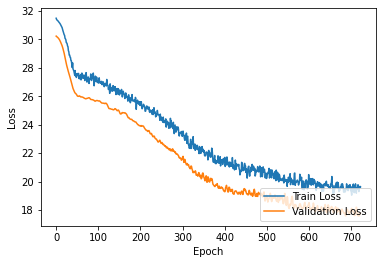

In [4]:
df = pd.read_pickle(f'../data/control.pkl')
error_values['control'] = run.run_control(df)

del df
gc.collect()

error_values['control']

#### Experiment One: Wind

Running DNN for dataset
1959/1959 [==============================] - 3s 2ms/step - loss: 12.8902 - mae: 12.8902 - mse: 555.3820


[12.890209197998047, 12.890209197998047, 555.3820190429688]

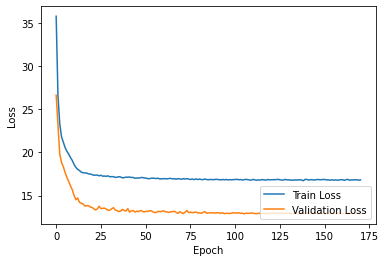

In [5]:
df = pd.read_pickle(f'../data/covidWind.{state}.pkl')
error_values['wind'] = run.run_wind(df)

del df
gc.collect()

error_values['wind']

#### Experiment Two: Pressure

Running DNN for dataset
983/983 [==============================] - 1s 695us/step - loss: 11.8575 - mae: 11.8575 - mse: 575.0713


[11.857532501220703, 11.857532501220703, 575.0712890625]

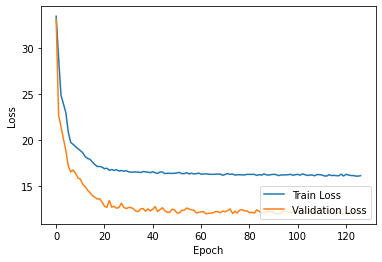

In [6]:
df = pd.read_pickle(f'../data/covidPressure.{state}.pkl')

error_values['pressure'] =  run.run_pressure(df)

del df
gc.collect()

error_values['pressure']

#### Experiment Three: Temperature

Running DNN for dataset
2207/2207 [==============================] - 4s 2ms/step - loss: 12.2571 - mae: 12.2571 - mse: 553.7136


[12.257142066955566, 12.257142066955566, 553.7135620117188]

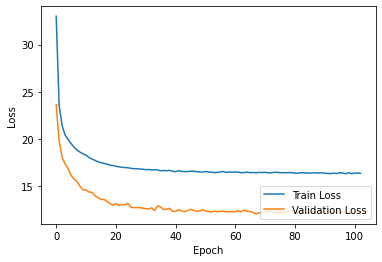

In [7]:
df = pd.read_pickle(f'../data/covidTemperature.{state}.pkl')
error_values['temperature'] = run.run_temperature(df)

del df
gc.collect()

error_values['temperature']

## Results

In [ ]:
print("mean_absolute_error")
for dsname, error_value in error_values.items():
    print(f"{dsname}\t\t{error_value}")

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20